In [1]:
# pip install albumentations

In [2]:
# pip install torchsummary

In [3]:
# pip install ipywidgets 

In [82]:
# !pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=feb5eafbdc4208ece84f79734633a239c3acbeebfe2a1bc3d81d7c434323056c
  Stored in directory: /opt/ml/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch


In [1]:
!jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

[I 03:08:35.091 NotebookApp] Writing notebook server cookie secret to /opt/ml/.local/share/jupyter/runtime/notebook_cookie_secret
[I 03:08:35.290 NotebookApp] The port 8888 is already in use, trying another port.
/opt/conda/lib/python3.7/site-packages/jupyter_server/transutils.py:13: FutureWarning: The alias `_()` will be deprecated. Use `_i18n()` instead.
  warnings.warn(warn_msg, FutureWarning)
[W 2021-04-06 03:08:36.701 LabApp] 'iopub_data_rate_limit' has moved from NotebookApp to ServerApp. This config will be passed to ServerApp. Be sure to update your config before our next release.
[W 2021-04-06 03:08:36.701 LabApp] 'iopub_data_rate_limit' has moved from NotebookApp to ServerApp. This config will be passed to ServerApp. Be sure to update your config before our next release.
[I 2021-04-06 03:08:36.706 LabApp] JupyterLab extension loaded from /opt/conda/lib/python3.7/site-packages/jupyterlab
[I 2021-04-06 03:08:36.706 LabApp] JupyterLab application directory is /opt/conda/share/ju

In [3]:
import os
import shutil
from glob import glob

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from albumentations import *
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchsummary import summary
import timm
from efficientnet_pytorch import EfficientNet

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

In [4]:
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
train_dir = 'input/data/train'
eval_dir = 'input/data/eval'

df_train = pd.read_csv(os.path.join(train_dir, 'train.csv')) 
df_eval = pd.read_csv(os.path.join(eval_dir, 'info.csv'))

# Data Processing

In [48]:
# create dictionary that has key : class, value : data path
np_train = np.array(df_train)
class_dic = {i : [] for i in range(18)}
for info in np_train:
    if info[1] == 'male':
        if info[3] < 30:
            class_num = 0
        elif info[3] >= 30 and info[3] < 58:
            class_num = 1
        else:
            class_num = 2
    elif info[1] == 'female':
        if info[3] < 30:
            class_num = 3
        elif info[3] >= 30 and info[3] < 60:
            class_num = 4
        else:
            class_num = 5
    
    img_list = sorted([img.split('/')[-1] for img in glob(f'{train_dir}/images/{info[4]}/*')])
    copy_class_dir = [1, 0, 0, 0, 0, 0, 2]
    for i in range(len(img_list)):
        target_dir = os.path.join(train_dir, 'images', info[4], img_list[i])
        class_dic[copy_class_dir[i]*6+class_num].append(target_dir)

In [49]:
# create list that has [path, class]
class_path = []
for c in class_dic:
    for path in class_dic[c]:
        class_path.append([path, c])
class_path = np.array(class_path)

In [50]:
# create list that has [path, class] for using one mask data by one person > down sampling 
tuned_class_path = []
for c in class_dic:
    if c <= 5:
        for path_idx in range(0, len(class_dic[c]), 5):
            tuned_class_path.append([class_dic[c][path_idx:path_idx+5], c])
    else:
        for path in class_dic[c]:
            tuned_class_path.append([path, c])
tuned_class_path = np.array(tuned_class_path)

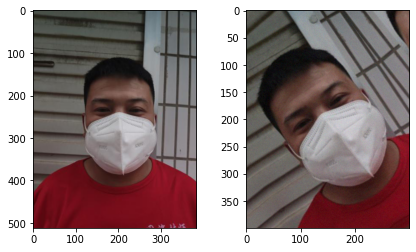

In [51]:
# compare original data and transformed data
sample_img = Image.open(class_path[0][0])
sample = np.array(sample_img)

fig, ax = plt.subplots(1, 2, figsize=(7,4))
ax[0].imshow(sample)

trfm = Compose([
    CenterCrop(400, 300, p=1.0),
    HorizontalFlip(p=0.5),
    ShiftScaleRotate(p=0.7),
    RandomBrightnessContrast(brightness_limit=(-0.1, 0.3), contrast_limit=(-0.1, 0.3), p=0.5),
    GaussNoise(p=0.7),
#     Normalize(mean=(0.560, 0.524, 0.501), std=(0.233, 0.243, 0.246), max_pixel_value=255.0, p=1.0),
#     ToTensorV2(p=1.0)
], p=1.0)
ax[1].imshow(trfm(image=sample)['image'])

# Dataset, DataLoader, Modeling

In [52]:
# for training
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

class F1Loss(nn.Module):
    def __init__(self, classes=18, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon
    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()    

# for metric
def metric_f1loss(y_true, y_pred):
    y_true = F.one_hot(y_true, 18).to(torch.float32)
    y_pred = F.softmax(y_pred, dim=1)

    tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

    epsilon=1e-7

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    f1 = f1.clamp(min=epsilon, max=1 - epsilon)
    return f1.mean().item()

In [53]:
# define argumentation function
def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.560, 0.524, 0.501), std=(0.233, 0.243, 0.246)):
    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
#             CenterCrop(img_size[0], img_size[1], p=1.0),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.7),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.3), contrast_limit=(-0.1, 0.3), p=0.5),
            GaussNoise(p=0.7),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0)
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
#             CenterCrop(img_size[0], img_size[1], p=1.0),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0)
        ], p=1.0)
    return transformations


# define dataset class
class ImageDataset(Dataset):
    def __init__(self, class_path, transform, tuned):
        self.class_path = class_path
        self.transform = transform
        self.tuned = tuned
    
    def set_transform(self, transform):
        self.transform = transform
    
    # tuned : for down sampling, using one mask data for one person
    def __getitem__(self, index):
        if not self.tuned:
            image = Image.open(self.class_path[index][0])
        
        elif self.tuned:
            if isinstance(self.class_path[index][0], list):
                image = Image.open(self.class_path[index][0][np.random.randint(0,5)])
            else:
                image = Image.open(self.class_path[index][0])
        
        if self.transform:
            image = self.transform(image=np.array(image))
            
        return image['image'], int(self.class_path[index][1])

    def __len__(self):
        return len(self.class_path)

In [54]:
TESTSIZE = 0.2

MODELNAME='effnetb3_celoss_nokfold_agefilter58_aug'

LR = 1e-4
EPOCHS = 15
PRINTEVERY = 1
BATCHSIZE = 32
SEED = 33
TUNED = False

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [55]:
# split into training set and validation set
if TESTSIZE == 0:
    train_class_path = class_path
    val_class_path = np.array([])
else:
    train_idx, val_idx = train_test_split(np.arange(len(class_path)), 
                                          stratify=class_path[:,1],
                                          test_size=TESTSIZE, random_state=SEED)
    train_class_path = class_path[train_idx,:]
    val_class_path = class_path[val_idx,:]

# when using down sampling, validation set dont have to use down sample data
if TUNED == True:
    val_class_path = []
    for idx, val in enumerate(val_class_path):
        if isinstance(val[0], list):
            for path in val[0]:
                val_class_path.append([path, val[1]])
        else:
            val_class_path.append(val)
    val_class_path = np.array(val_class_path)

In [56]:
# set Dataset and DataLoader
transform = get_transforms()
train_dataset = ImageDataset(train_class_path, transform=None, tuned=TUNED)
train_dataset.set_transform(transform['train'])

val_dataset = ImageDataset(val_class_path, transform=None, tuned=TUNED)
val_dataset.set_transform(transform['val'])

torch.cuda.empty_cache()

train_tuned_loader = DataLoader(
    train_dataset,
    batch_size = BATCHSIZE,
    num_workers = 2,
    shuffle = True
)
if TESTSIZE != 0:
    val_loader = DataLoader(
        val_dataset,
        batch_size = BATCHSIZE,
        num_workers = 2,
        shuffle = True
    )


# set pretrained model
model_type = MODELNAME.split('_')[0]
if model_type == 'effnetb3':
    model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=18)
elif model_type == 'resnet50':
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(in_features=2048, out_features=18, bias=True)
elif model_type == 'resnet101':
    model = models.resnet101(pretrained=True)
    model.fc = nn.Linear(in_features=2048, out_features=18, bias=True)

model.to(device)

loss = nn.CrossEntropyLoss()
optm = optim.Adam(model.parameters(), lr=LR)


# make dir that save model
if not os.path.isdir('models'):
    os.makedirs("models")

if not os.path.isdir(f'models/{MODELNAME}'):
    os.makedirs(f'models/{MODELNAME}')
else:
    assert not os.path.isdir(f'models/{MODELNAME}'), 'saved model directory already exist'

Loaded pretrained weights for efficientnet-b3


AssertionError: saved model directory already exist

# Learning Model

In [57]:
# learning
torch.cuda.empty_cache()
best_val_f1 = 0
for epoch in range(EPOCHS):
    train_loss_list = []
    train_f1_list = []
    train_acc_list = []
    # compare to sklearn f-1 score
    train_skl_f1_list = []

    # training process
    for x, y in tqdm(train_tuned_loader):
        train_x = x.to(device)
        train_y = y.to(device)

        train_pred = model(train_x)
        train_loss = loss(train_pred, train_y)

        optm.zero_grad()
        train_loss.backward()
        optm.step()

        train_pred_class = torch.max(train_pred, 1)[1]
        train_acc = torch.sum(train_pred_class == train_y).item() / len(train_y)
        train_f1 = metric_f1loss(train_y, train_pred)

        train_loss_list.append(train_loss.item())
        train_f1_list.append(train_f1)
        train_acc_list.append(train_acc)

        # compare to sklearn f-1 score
        a=F.one_hot(train_y, num_classes=18).cpu().numpy()
        b=F.one_hot(train_pred_class, num_classes=18).cpu().numpy()
        train_skl_f1_list.append(f1_score(a, b, average='macro', labels=np.unique(b)))
    
    # evaluate process for train, val split data
    if TESTSIZE != 0:
        if (epoch % PRINTEVERY == 0) or (epoch == EPOCHS-1):
            val_loss_list = []
            val_f1_list = []
            val_acc_list = []
            # compare to sklearn f-1 score
            val_skl_f1_list = []

            with torch.no_grad():
                model.eval()
                for x, y in val_loader:
                    val_x = x.to(device)
                    val_y = y.to(device)

                    val_pred = model(val_x)
                    val_loss = loss(val_pred, val_y)

                    val_pred_class = torch.max(val_pred, 1)[1]
                    val_acc = torch.sum(val_pred_class == val_y).item() / len(val_y)
                    val_f1 = metric_f1loss(val_y, val_pred)

                    val_loss_list.append(val_loss.item())
                    val_f1_list.append(val_f1)
                    val_acc_list.append(val_acc)

                    # compare to sklearn f-1 score
                    a=F.one_hot(val_y, num_classes=18).cpu().numpy()
                    b=F.one_hot(val_pred_class, num_classes=18).cpu().numpy()
                    val_skl_f1_list.append(f1_score(a, b, average='macro', labels=np.unique(b)))

            model.train()

            final_val_f1 = np.mean(val_f1_list)

            print(f'* Epoch : {epoch}')
            print(f'mean train loss : {np.mean(train_loss_list):.3f}, mean train f1 : {np.mean(train_f1_list):.3f}, mean train acc : {np.mean(train_acc_list):.3f}')
            print(f'       val loss : {np.mean(val_loss_list):.3f},        val f1 : {final_val_f1:.3f},        val acc : {np.mean(val_acc_list):.3f}')

            # compare to sklearn f-1 score
            print(f'sklearn train f1 : {np.mean(train_skl_f1_list):.3f}, sklearn val f1 : {np.mean(val_skl_f1_list):.3f}\n')

        # save model
        if final_val_f1 > 0.5: # and final_val_f1 > best_val_f1-0.003:
            if final_val_f1 > best_val_f1:
                best_val_f1 = final_val_f1

            save_folder = f'models/{MODELNAME}'
            model_name = f'{epoch:0>2}_{np.mean(train_f1_list):.3f}_{np.mean(val_f1_list):.3f}_{np.mean(val_skl_f1_list):.3f}'
            save_path = f'{save_folder}/{model_name}.pth'
            torch.save(model.state_dict(), save_path)
            print(f'Saved models : {save_path}\n')
    
    # save model for training set using all data
    elif TESTSIZE == 0: 
        save_folder = f'models/{MODELNAME}'
        model_name = f'{epoch:0>2}_alltraining'
        save_path = f'{save_folder}/{model_name}.pth'
        torch.save(model.state_dict(), save_path)
        print(f'Saved models : {save_path}\n')

  0%|          | 0/472 [00:00<?, ?it/s]

* Epoch : 0
mean train loss : 0.778, mean train f1 : 0.340, mean train acc : 0.777
       val loss : 0.269,        val f1 : 0.491,        val acc : 0.906
sklearn train f1 : 0.721, sklearn val f1 : 0.852



  0%|          | 0/472 [00:00<?, ?it/s]

* Epoch : 1
mean train loss : 0.269, mean train f1 : 0.501, mean train acc : 0.907
       val loss : 0.213,        val f1 : 0.528,        val acc : 0.922
sklearn train f1 : 0.857, sklearn val f1 : 0.850

Saved models : models/effnetb3_celoss_nokfold_agefilter58_aug/01_0.501_0.528_0.850.pth



  0%|          | 0/472 [00:00<?, ?it/s]

* Epoch : 2
mean train loss : 0.179, mean train f1 : 0.538, mean train acc : 0.939
       val loss : 0.083,        val f1 : 0.578,        val acc : 0.974
sklearn train f1 : 0.882, sklearn val f1 : 0.942

Saved models : models/effnetb3_celoss_nokfold_agefilter58_aug/02_0.538_0.578_0.942.pth



  0%|          | 0/472 [00:00<?, ?it/s]

* Epoch : 3
mean train loss : 0.125, mean train f1 : 0.560, mean train acc : 0.960
       val loss : 0.067,        val f1 : 0.580,        val acc : 0.979
sklearn train f1 : 0.912, sklearn val f1 : 0.925

Saved models : models/effnetb3_celoss_nokfold_agefilter58_aug/03_0.560_0.580_0.925.pth



  0%|          | 0/472 [00:00<?, ?it/s]

* Epoch : 4
mean train loss : 0.081, mean train f1 : 0.579, mean train acc : 0.973
       val loss : 0.050,        val f1 : 0.596,        val acc : 0.985
sklearn train f1 : 0.931, sklearn val f1 : 0.947

Saved models : models/effnetb3_celoss_nokfold_agefilter58_aug/04_0.579_0.596_0.947.pth



  0%|          | 0/472 [00:00<?, ?it/s]

* Epoch : 5
mean train loss : 0.064, mean train f1 : 0.594, mean train acc : 0.982
       val loss : 0.067,        val f1 : 0.608,        val acc : 0.979
sklearn train f1 : 0.946, sklearn val f1 : 0.922

Saved models : models/effnetb3_celoss_nokfold_agefilter58_aug/05_0.594_0.608_0.922.pth



  0%|          | 0/472 [00:00<?, ?it/s]

* Epoch : 6
mean train loss : 0.049, mean train f1 : 0.600, mean train acc : 0.986
       val loss : 0.062,        val f1 : 0.604,        val acc : 0.978
sklearn train f1 : 0.949, sklearn val f1 : 0.950

Saved models : models/effnetb3_celoss_nokfold_agefilter58_aug/06_0.600_0.604_0.950.pth



  0%|          | 0/472 [00:00<?, ?it/s]

* Epoch : 7
mean train loss : 0.047, mean train f1 : 0.597, mean train acc : 0.984
       val loss : 0.048,        val f1 : 0.607,        val acc : 0.987
sklearn train f1 : 0.939, sklearn val f1 : 0.944

Saved models : models/effnetb3_celoss_nokfold_agefilter58_aug/07_0.597_0.607_0.944.pth



  0%|          | 0/472 [00:00<?, ?it/s]

* Epoch : 8
mean train loss : 0.036, mean train f1 : 0.606, mean train acc : 0.988
       val loss : 0.031,        val f1 : 0.609,        val acc : 0.992
sklearn train f1 : 0.950, sklearn val f1 : 0.936

Saved models : models/effnetb3_celoss_nokfold_agefilter58_aug/08_0.606_0.609_0.936.pth



  0%|          | 0/472 [00:00<?, ?it/s]

* Epoch : 9
mean train loss : 0.028, mean train f1 : 0.609, mean train acc : 0.993
       val loss : 0.022,        val f1 : 0.610,        val acc : 0.996
sklearn train f1 : 0.958, sklearn val f1 : 0.969

Saved models : models/effnetb3_celoss_nokfold_agefilter58_aug/09_0.609_0.610_0.969.pth



  0%|          | 0/472 [00:00<?, ?it/s]

* Epoch : 10
mean train loss : 0.031, mean train f1 : 0.610, mean train acc : 0.990
       val loss : 0.023,        val f1 : 0.618,        val acc : 0.994
sklearn train f1 : 0.961, sklearn val f1 : 0.969

Saved models : models/effnetb3_celoss_nokfold_agefilter58_aug/10_0.610_0.618_0.969.pth



  0%|          | 0/472 [00:00<?, ?it/s]

* Epoch : 11
mean train loss : 0.033, mean train f1 : 0.611, mean train acc : 0.988
       val loss : 0.024,        val f1 : 0.617,        val acc : 0.994
sklearn train f1 : 0.949, sklearn val f1 : 0.956

Saved models : models/effnetb3_celoss_nokfold_agefilter58_aug/11_0.611_0.617_0.956.pth



 10%|▉         | 45/472 [00:27<04:22,  1.63it/s]


KeyboardInterrupt: 

In [29]:
import gc 
gc.collect()

6201

In [18]:
!nvidia-smi

Thu Apr  8 02:10:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   34C    P0    42W / 250W |  32467MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [55]:
# k-fold learning
skf = StratifiedKFold(n_splits=4, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(skf.split(class_path[:,0], class_path[:,1])):
    print(f"*fold : {fold}")
    
    # create directory to save model by fold
    if not os.path.isdir(f'models/{MODELNAME}/{fold}'):
        os.makedirs(f'models/{MODELNAME}/{fold}')
    
    
    # set Dataset and DataLoader
    train_class_path = class_path[train_idx,:]
    val_class_path = class_path[val_idx,:]
    
    torch.cuda.empty_cache()
    
    transform = get_transforms()
    train_dataset = ImageDataset(train_class_path, transform=None, tuned=False)
    train_dataset.set_transform(transform['train'])

    val_dataset = ImageDataset(val_class_path, transform=None, tuned=False)
    val_dataset.set_transform(transform['val'])
    
    train_tuned_loader = DataLoader(
        train_dataset,
        batch_size = BATCHSIZE,
        num_workers = 2,
        shuffle = True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size = BATCHSIZE,
        num_workers = 2,
        shuffle = True
    )
    
    
    # set pretrained model
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(in_features=2048, out_features=18, bias=True)
    model.to(device)

    loss = nn.CrossEntropyLoss()
    optm = optim.Adam(model.parameters(), lr=LR)
    
    
    # learning
    best_val_f1 = 0
    for epoch in range(EPOCHS):
        train_loss_list = []
        train_f1_list = []
        train_acc_list = []
        # compare to sklearn f-1 score
        train_skl_f1_list = []

        # training process
        for x, y in tqdm(train_tuned_loader):
            train_x = x.to(device)
            train_y = y.to(device)

            train_pred = model(train_x)
            train_loss = loss(train_pred, train_y)

            optm.zero_grad()
            train_loss.backward()
            optm.step()

            train_pred_class = torch.max(train_pred, 1)[1]
            train_acc = torch.sum(train_pred_class == train_y).item() / len(train_y)
            train_f1 = metric_f1loss(train_y, train_pred)

            train_loss_list.append(train_loss.item())
            train_f1_list.append(train_f1)
            train_acc_list.append(train_acc)

            # compare to sklearn f-1 score
            a=F.one_hot(train_y, num_classes=18).cpu().numpy()
            b=F.one_hot(train_pred_class, num_classes=18).cpu().numpy()
            train_skl_f1_list.append(f1_score(a, b, average='macro', labels=np.unique(b)))

        # inference process
        if (epoch % PRINTEVERY == 0) or (epoch == EPOCHS-1):
            val_loss_list = []
            val_f1_list = []
            val_acc_list = []
            # compare to sklearn f-1 score
            val_skl_f1_list = []

            with torch.no_grad():
                model.eval()
                for x, y in val_loader:
                    val_x = x.to(device)
                    val_y = y.to(device)

                    val_pred = model(val_x)
                    val_loss = loss(val_pred, val_y)

                    val_pred_class = torch.max(val_pred, 1)[1]
                    val_acc = torch.sum(val_pred_class == val_y).item() / len(val_y)
                    val_f1 = metric_f1loss(val_y, val_pred)

                    val_loss_list.append(val_loss.item())
                    val_f1_list.append(val_f1)
                    val_acc_list.append(val_acc)

                    # compare to sklearn f-1 score
                    a=F.one_hot(val_y, num_classes=18).cpu().numpy()
                    b=F.one_hot(val_pred_class, num_classes=18).cpu().numpy()
                    val_skl_f1_list.append(f1_score(a, b, average='macro', labels=np.unique(b)))

            model.train()

            final_val_f1 = np.mean(val_f1_list)

            print(f'* Epoch : {epoch}')
            print(f'mean train loss : {np.mean(train_loss_list):.3f}, mean train f1 : {np.mean(train_f1_list):.3f}, mean train acc : {np.mean(train_acc_list):.3f}')
            print(f'       val loss : {np.mean(val_loss_list):.3f},        val f1 : {final_val_f1:.3f},        val acc : {np.mean(val_acc_list):.3f}')

            # compare to sklearn f-1 score
            print(f'sklearn train f1 : {np.mean(train_skl_f1_list):.3f}, sklearn val f1 : {np.mean(val_skl_f1_list):.3f}\n')

        # save model
        if final_val_f1 > best_val_f1-0.003 and final_val_f1 > 0.5:
            if final_val_f1 > best_val_f1:
                best_val_f1 = final_val_f1

            save_folder = f'models/{MODELNAME}/{fold}'
            model_name = f'{epoch:0>2}_{np.mean(train_f1_list):.3f}_{np.mean(val_f1_list):.3f}_{np.mean(val_skl_f1_list):.3f}'
            save_path = f'{save_folder}/{model_name}.pth'
            torch.save(model.state_dict(), save_path)
            print(f'Saved models : {save_path}\n')

*fold : 0


  1%|          | 3/442 [00:01<04:30,  1.62it/s]


KeyboardInterrupt: 